### Mount Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


### Install Packagaes

In [3]:
#!sudo apt install easyocr --quiet
!pip install pdf2image --quiet
!apt-get install poppler-utils --quiet




Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 0s (860 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 155653 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [4]:
!pip install easyocr --quiet
import easyocr
import cv2
from pdf2image import convert_from_path
import tempfile
import os
import glob
from os import listdir
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from google.colab.patches import cv2_imshow
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


     |████████████████████████████████| 70.8 MB 450 kB/s 
     |████████████████████████████████| 47.6 MB 72.4 MB/s 


### Modified PDf from 500 dataset: 5f4212d7-7bb7-45e5-9d74-3c1e26770e55.pdf

Trimmed the main Sustainabilty pages: 20 pages


In [5]:
sample_pdf = "/content/drive/MyDrive/SustainLab/Modified_5f4212d7-7bb7-45e5-9d74-3c1e26770e55.pdf"

### Loading easyOCr english module

In [6]:
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### OpenCV SOP for creating bounding boxes:

- Main Goal: Find the Structure of the document. (Column-wise bounding boxes)

- Idea : Blur the image (adding noise) to help Open CV identify the structure.

### Procedure to Blur: These are standard SOPs(Standard Operating Procedure)

1. Change color of image to gray
2. Blur the image
3. Apply Thresh : Background is black and foreground is white
4. Kernal : Pre-requisite for 'dilate'
5. Dilate : Make text unreadable so that only paragraphs structure remain visible 

### Function for SOPs (identifying structure of the document using OpenCV)

In [7]:
def manipulate_img(rd_img):
  # convert colored image to gray and save it 'temp' folder
  gray = cv2.cvtColor(rd_img,cv2.COLOR_BGR2GRAY)
  cv2.imwrite("/content/drive/MyDrive/SustainLab/temp/Pages4_gray.png",gray)
  # Apply Gaussian Blur
  blur=cv2.GaussianBlur(gray,(7,7),0)
  cv2.imwrite("/content/drive/MyDrive/SustainLab/temp/Pages4_blur.png",blur)
  # Apply Thresh
  thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  cv2.imwrite("/content/drive/MyDrive/SustainLab/temp/Pages4_THRESH.png",thresh)
  # Apply Kernal
  kernal =cv2.getStructuringElement(cv2.MORPH_RECT,(3,13))
  cv2.imwrite("/content/drive/MyDrive/SustainLab/temp/Pages4_kernal.png",kernal)
  # Apply Dilate
  dilate = cv2.dilate(thresh,kernal,iterations=2)
  cv2.imwrite("/content/drive/MyDrive/SustainLab/temp/Pages4_dilate.png",dilate)
  #cnts.append(conturs)
  
  return(dilate)


### Function to draw Bounding Boxes on the images

In [8]:
crop_img=[]
def bbox(contours_array,orig_img):
  i=0
  for c in contours_array:
    x,y,w,h = cv2.boundingRect(c)
    
    # Save bounding boxes only if the height is >200 and width >20
    if h > 200 and w > 20:
      roi= orig_img[y:y+h,x:x+h]
      #cv2.rectangle(read_img,(x,y),(x+w, y+h),(36,255,12),2)
      draw_bbox= cv2.rectangle(orig_img,(x,y),(x+w, y+h),(0,255,0),2)

      #crop image
      cropped_image = orig_img[y:y+h, x:x+w]
      crop_img.append(cropped_image)
      #plt.imshow(cropped_image)

      i += 1 

  return (draw_bbox)

In [9]:
read_img=[]
cnts=[]
image_path= r'/content/drive/MyDrive/SustainLab'
images = convert_from_path(sample_pdf)
for i in range(len(images)):
  images[i].save('/content/drive/MyDrive/SustainLab/Pages'+ str(i) +'.jpg', 'JPEG')
  read_img_temp = cv2.imread('/content/drive/MyDrive/SustainLab/Pages'+str(i) +'.jpg')
  read_img.append(read_img_temp)
  dialate_raw=manipulate_img(read_img_temp)
  conturs=cv2.findContours(dialate_raw,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  conturs=conturs[0] if len(conturs) == 2 else conturs[1]
  conturs = sorted(conturs, key = cv2.contourArea, reverse = True)
  cnts.append(conturs)
  final_bbox=bbox(conturs,read_img_temp)
  bbox_sample=cv2.imwrite("/content/drive/MyDrive/SustainLab/temp/Pages_bbox" +str(i) +".jpg",final_bbox)



In [10]:
len(read_img)

20

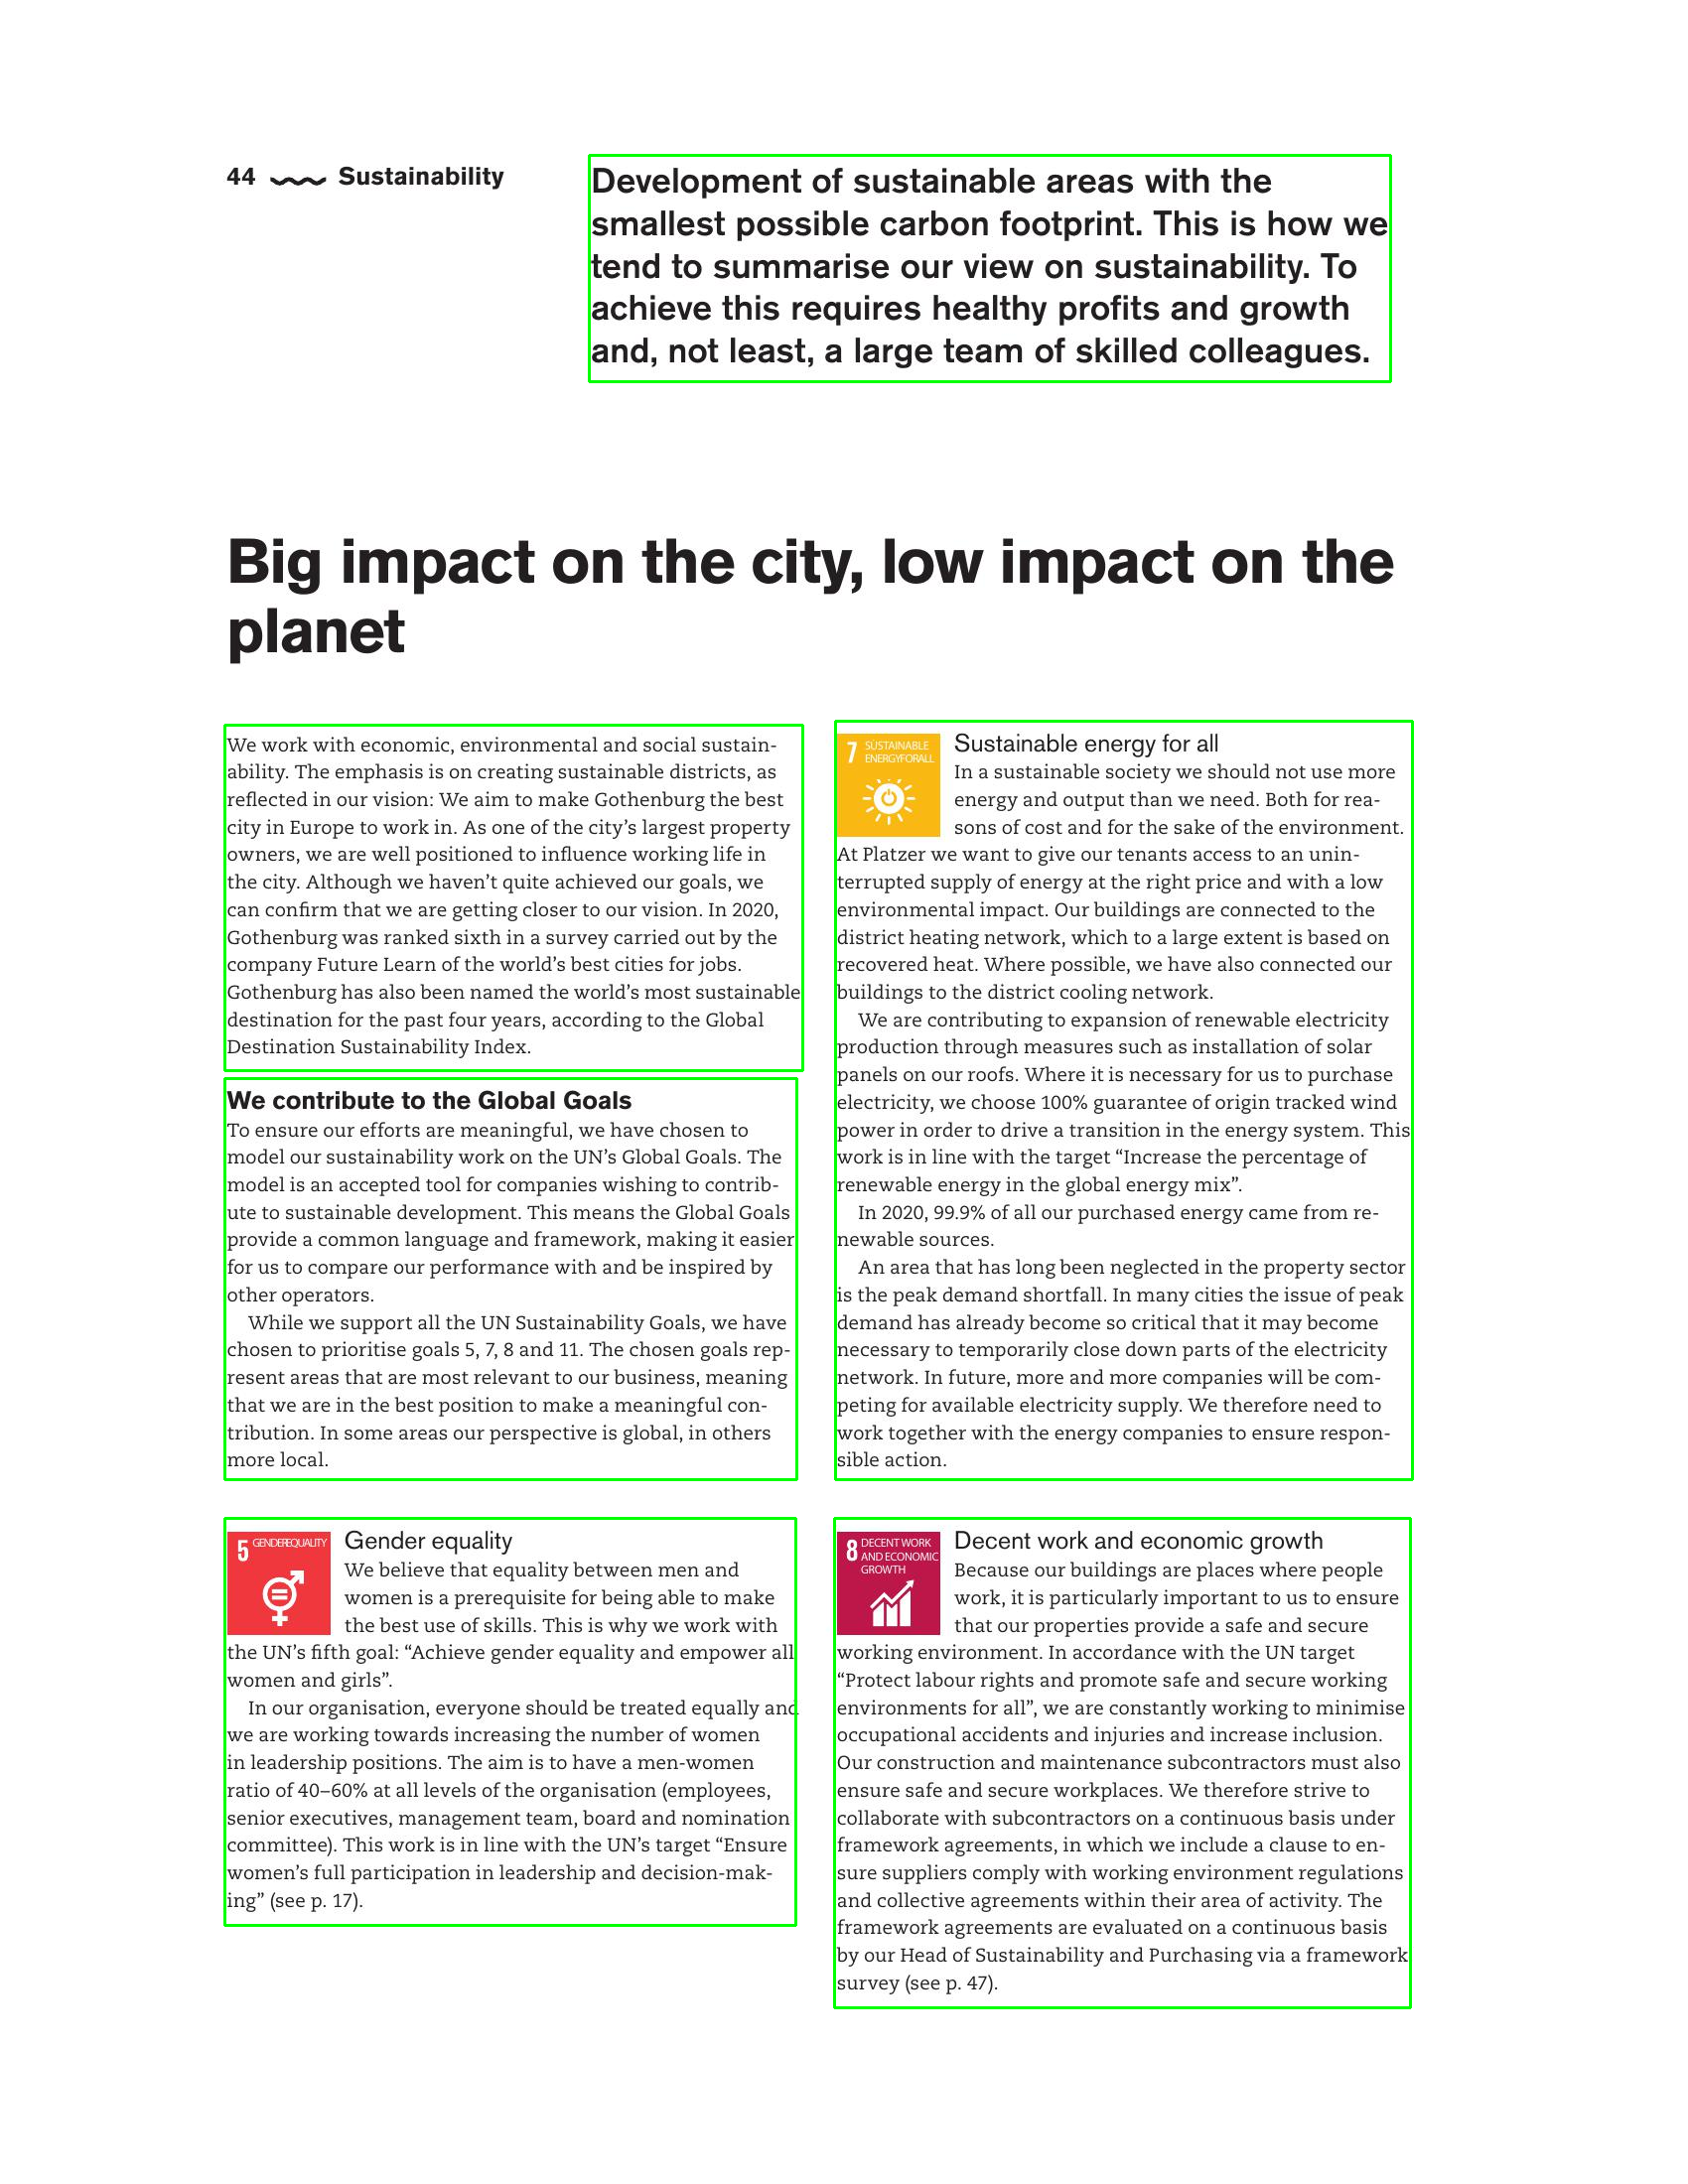

In [11]:
#plt.imshow(read_img[2])
cv2_imshow(read_img[2])

In [13]:
len(crop_img)

136

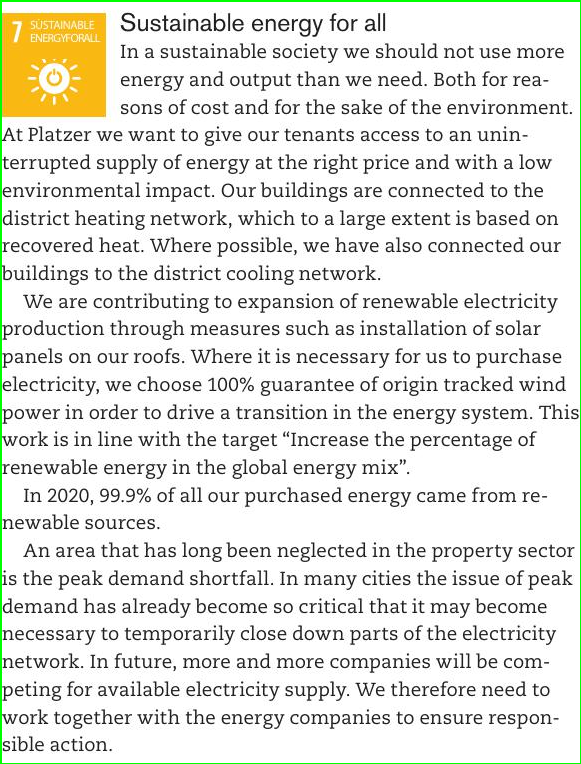

In [14]:
#plt.imshow(crop_img[4])
cv2_imshow(crop_img[4])

### OCR each of the cropped image

- Done using EasyOcr

In [15]:
text=''
for i in range (len(crop_img)):
  detection = reader.readtext(crop_img[i],decoder='beamsearch')
  #ocr_text(detection)
  for j in range(len(detection)):
    text = text + detection[j][1] +'\n'

### Ocr'd raw text saved in a "str" variable

In [16]:
print(text)
type(text)

42
Sustainability
Sua inability
Early morning by the quayside and most people living in Gothenburg are on their way to work
The building visible behind the hoarding is Packhuskajen 6, which is fully let to the Swedish
National Courts Administration, the Court of Appeal for Western Sweden:
43
Sustainabill
SUSTAINABLE
Sustainable energy for all
ENEGKORNL
In a sustainable
society we should not use more
energy and output than we need: Both for rea-
sons of cost and for the sake of the environment
At Platzer we want to give our tenants access to an unin-
terrupted supply of energy at the right
and with a low
environmental impact: Our buildings are connected to the
district heating network; which to a
extent is based on
recovered heat: Where possible; we have also connected our
buildings to the district cooling network
We are
contributing to expansion of renewable electricity
production through measures such as installation of solar
panels on our roofs_
Where it is necessary for uS to purcha

str

### Save the raw extracted text in a .txt file

In [17]:

text_file = open("/content/drive/MyDrive/SustainLab/Output/All_Pages_Raw_Extract.txt", "w")
n = text_file.write(text)
text_file.close()

### Use regex to combine all sentences in 1 single line

In [18]:
with open('/content/drive/MyDrive/SustainLab/Output/All_Pages_Raw_Extract.txt') as f:

    exampleText = f.read()

new = ''

for line in exampleText.split('\n'):
    if line == '':
        new += '\n\n'
    elif re.search('[a-zA-Z]', line):  # check if there is text
        new += line + ' ' 
    else:
        new += line + '\n' 

In [19]:
print(new)
type(new)

42
Sustainability Sua inability Early morning by the quayside and most people living in Gothenburg are on their way to work The building visible behind the hoarding is Packhuskajen 6, which is fully let to the Swedish National Courts Administration, the Court of Appeal for Western Sweden: 43
Sustainabill SUSTAINABLE Sustainable energy for all ENEGKORNL In a sustainable society we should not use more energy and output than we need: Both for rea- sons of cost and for the sake of the environment At Platzer we want to give our tenants access to an unin- terrupted supply of energy at the right and with a low environmental impact: Our buildings are connected to the district heating network; which to a extent is based on recovered heat: Where possible; we have also connected our buildings to the district cooling network We are contributing to expansion of renewable electricity production through measures such as installation of solar panels on our roofs_ Where it is necessary for uS to purcha

str

### Use regex patten Matching and Substitution

- Pattern matching for '.' and ':'

- ":" because Easyocr is replacing "." with ":" while OCR'ing - That is comimg from the algorithm.

In [20]:
regex = r"(?<=\.|\?|\:|\_)\s"
test_str = new
subst = "\\n"
result = re.sub(regex, subst, test_str, 0, re.MULTILINE)
if result:
  print (result)

type(result)

42
Sustainability Sua inability Early morning by the quayside and most people living in Gothenburg are on their way to work The building visible behind the hoarding is Packhuskajen 6, which is fully let to the Swedish National Courts Administration, the Court of Appeal for Western Sweden:
43
Sustainabill SUSTAINABLE Sustainable energy for all ENEGKORNL In a sustainable society we should not use more energy and output than we need:
Both for rea- sons of cost and for the sake of the environment At Platzer we want to give our tenants access to an unin- terrupted supply of energy at the right and with a low environmental impact:
Our buildings are connected to the district heating network; which to a extent is based on recovered heat:
Where possible; we have also connected our buildings to the district cooling network We are contributing to expansion of renewable electricity production through measures such as installation of solar panels on our roofs_
Where it is necessary for uS to purcha

str

### Save the Extracted sentences in a .txt file

- because the text is now character based because of regex usage

In [21]:

text_file = open("/content/drive/MyDrive/SustainLab/Output/Final_Extracted_AllPages.txt", "w")
n = text_file.write(result)
text_file.close()

### Create dataframe to pull all text into CSV

In [22]:
df2 = pd.DataFrame(columns=["Sent_extracted"])
df2

,Sent_extracted


In [23]:
final_extract = open('/content/drive/MyDrive/SustainLab/Output/Final_Extracted_AllPages.txt', 'r')

Lines = final_extract.readlines()

count=0
for line in Lines:
  count += 1
  df2 = df2.append({"Sent_extracted": line.strip()}, ignore_index=True)


### Save Extracted text in CSV file

In [24]:
df2.to_csv("/content/drive/MyDrive/SustainLab/Output/Final_Extracted_text_AllPages_5f4212d7-7bb7-45e5-9d74-3c1e26770e55.csv",index=False)


In [ ]:
df2